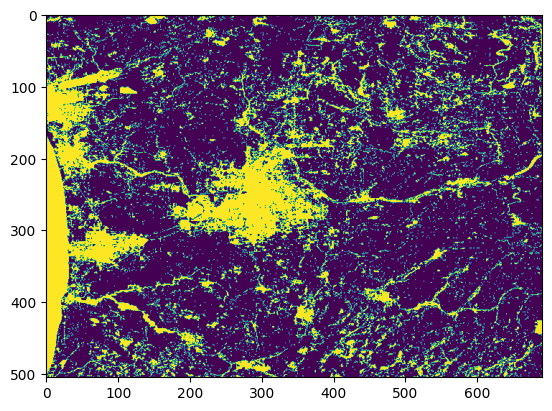

<Axes: >

In [ ]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

msa_file = '../urban_greening/msa/michiganMSA_reprojected.shp'
gpp_file = "../urban_greening/nov.15/michigan_test/modis-250-gpp-2015001.tif"
outRas = 'test1.tif'
nlcd_file = "../urban_greening/nov.15/nlcd_2016_land_cover_l48_20210604.img"
ua_file = "../urban_greening/gis_processed/ua/ua_30.tif"


msa=gpd.read_file(msa_file)
msa=msa[msa['NAMELSAD']=='Grand Rapids-Wyoming-Kentwood, MI Metro Area'] # Subsetting to my AOI



with rasterio.open(gpp_file) as gpp_dstrd:
    msa_crsgpp=msa.to_crs(gpp_dstrd.crs)
    msa_crs = msa_crsgpp.crs
    gpp_crs = gpp_dstrd.crs
    gpp_clip_image, gpp_clip_transform=mask(gpp_dstrd,msa_crsgpp.geometry,crop=True, filled=False) #filled false
    

    # replace fillvalue 65535 with np.nan
    gpp_clip_image = np.where(gpp_clip_image == 65535, np.nan, gpp_clip_image) 

    gpp_msa = gpp_clip_image[0]

    from shapely.geometry import mapping
    geometries = [mapping(geom) for geom in msa.geometry]

    with rasterio.open(nlcd_file) as nlcd_dstrd:
        nlcd_crs = nlcd_dstrd.crs
        
        msa_crsr = msa.to_crs(nlcd_crs)
        
        
        
        # Clip the raster using the reprojected geometries
        nlcd_clip_image, nlcd_clip_transform = mask(nlcd_dstrd, geometries, crop=True)
        
        nlcd_msa = nlcd_clip_image[0]

        

        import numpy as np
        gpp_msa_rr = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=np.float32) #make it support nan
        # gpp_msa_rr = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=gpp_dstrd.meta['dtype']), 
        from rasterio.enums import Resampling
        from rasterio.warp import calculate_default_transform, reproject
        reproject(
            source=gpp_msa,
            destination=gpp_msa_rr,
            src_transform=gpp_clip_transform,
            src_crs=gpp_crs,
            dst_transform=nlcd_clip_transform,
            dst_crs=nlcd_crs,
            resampling=Resampling.nearest, # use nearest to prevent unreasonable upscaling
            src_nodata=np.nan
        )
        
       

        with rasterio.open(ua_file) as ua_dstrd:
            ua_crs = ua_dstrd.crs

            ua_clip_image, ua_clip_transform = mask(ua_dstrd, geometries, crop=True)
            ua_msa = ua_clip_image[:][:][0]

            import numpy as np
            ua_msa_rr = np.empty((ua_clip_image.shape[1], ua_clip_image.shape[2]), dtype=ua_dstrd.meta['dtype'])

            from rasterio.enums import Resampling
            from rasterio.warp import calculate_default_transform, reproject
            reproject(
                source=ua_msa,
                destination=ua_msa_rr,
                src_transform=ua_clip_transform,
                src_crs=ua_crs,
                dst_transform=nlcd_clip_transform,
                dst_crs=nlcd_crs,
                resampling=Resampling.nearest
            )

        nee_month_us_file = '../output/nee.tif'
        with rasterio.open(nee_month_us_file) as nee_dstrd:
            nee_crs = gpp_crs
            
            # clip nee raster with shape
            nee_clip_image, nee_clip_transform = mask(nee_dstrd, [mapping(geom) for geom in msa_crsgpp.geometry], crop=True, all_touched=True)  # Include all touched pixels)
            nee_clip_image = np.where(nee_clip_image == -9999, np.nan, nee_clip_image) 
            
            nee_msa = nee_clip_image[0]
            nee_msa_fine = np.empty((nlcd_clip_image.shape[1], nlcd_clip_image.shape[2]), dtype=np.float32)
            reproject(
                source=nee_msa,
                destination=nee_msa_fine,
                src_transform=nee_clip_transform,
                src_crs=nee_crs,
                dst_transform=nlcd_clip_transform,
                dst_crs=nlcd_crs,
                resampling=Resampling.nearest, # use nearest to prevent unreasonable upscaling
                src_nodata=-9999
            )
        

rasterio.plot.show(gpp_msa)


In [52]:
np.unique(gpp_msa, return_counts=True)

(array([0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
        5.0000e+00, 6.0000e+00, 7.0000e+00, 8.0000e+00, 9.0000e+00,
        1.0000e+01, 1.1000e+01, 1.2000e+01, 1.3000e+01, 1.4000e+01,
        1.5000e+01, 1.6000e+01, 1.7000e+01, 1.8000e+01, 1.9000e+01,
        2.0000e+01, 2.1000e+01, 2.2000e+01, 2.3000e+01, 2.4000e+01,
        2.5000e+01, 2.6000e+01, 2.7000e+01, 2.9000e+01, 3.0000e+01,
        3.1000e+01, 3.3000e+01, 6.5535e+04]),
 array([24663, 35671, 38090, 40296, 38188, 32508, 22315, 13785,  7364,
         4132,  2259,  1227,   686,   359,   201,   138,    91,    55,
           44,    41,    22,    20,    11,    10,     7,     4,     3,
            6,     2,     1,     1,     1, 86754]))

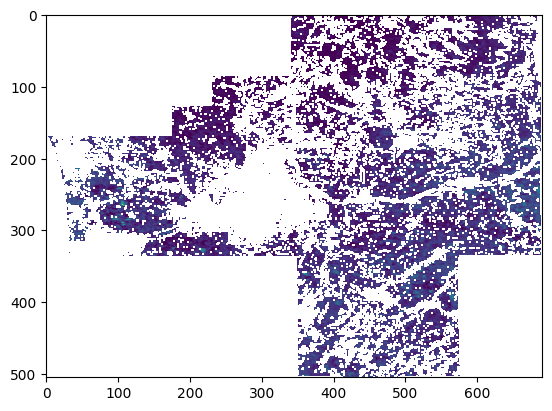

<Axes: >

In [19]:
nee_clip_transform


Affine(0.083333333, 0.0, -86.33333370800001,
       0.0, -0.083333333, 43.499999466)

In [3]:
nee_clip_transform

Affine(0.083333333, 0.0, -86.33333370800001,
       0.0, -0.083333333, 43.499999466)

In [25]:
def save_tiff(output_file, output_path, crs, transform):
    # Write the ndarray to a GeoTIFF
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=output_file.shape[0],
        width=output_file.shape[1],
        count=1,  # Number of bands
        dtype=output_file.dtype,
        crs=crs,
        transform=transform,
        # nodata=np.nan, # do not set this or there will be reprojet edge with value 0
    ) as dst:
        # Write data to the first band
        dst.write(output_file, 1)

    print(f"GeoTIFF saved to {output_path}")

In [26]:

save_tiff(nee_msa, '../output/nee_msa1.tif', nee_crs, nee_clip_transform)

GeoTIFF saved to ../output/nee_msa1.tif


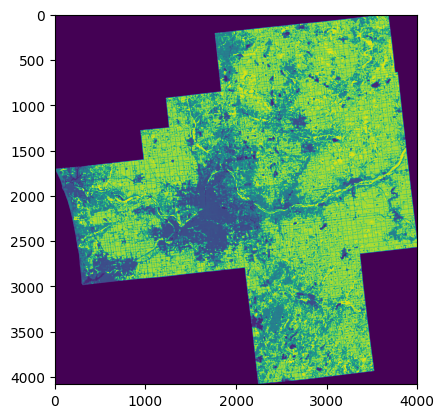

<Axes: >

In [27]:
rasterio.plot.show(nlcd_msa)

In [ ]:
# # Metadata for the output TIFF
# output_path = "gpp_msa_rr_beforefillnearestfloatwithnan.tif"

# # Write the ndarray to a GeoTIFF
# with rasterio.open(
#     output_path,
#     "w",
#     driver="GTiff",
#     height=gpp_msa_rr.shape[0],
#     width=gpp_msa_rr.shape[1],
#     count=1,  # Number of bands
#     dtype=gpp_msa_rr.dtype,
#     crs=nlcd_crs,
#     transform=nlcd_clip_transform,
#     # nodata=np.nan, # do not set this or there will be reprojet edge with value 0
# ) as dst:
#     # Write data to the first band
#     dst.write(gpp_msa_rr, 1)

# print(f"GeoTIFF saved to {output_path}")

CPLE_AppDefinedError: Deleting gpp_msa_rr_beforefillnearestfloatwithnan.tif failed: Permission denied

In [183]:
np.unique(gpp_msa_rr == np.nan, return_counts=True)

(array([False]), array([16328081]))

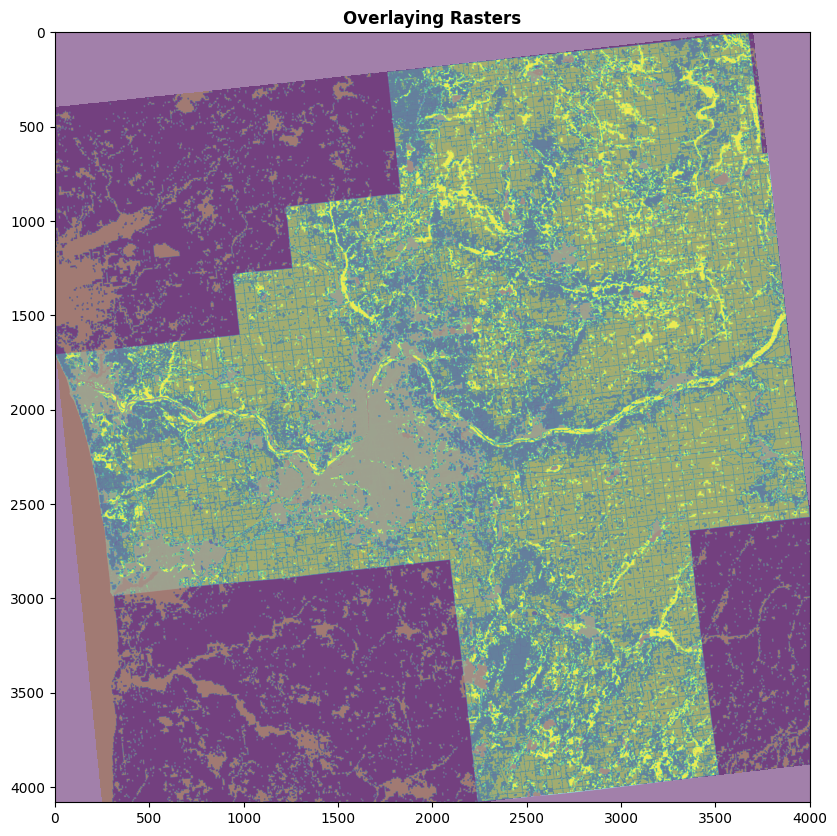

In [29]:
from rasterio import plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
# Show the first raster
rasterio.plot.show(gpp_msa_rr, ax=ax, alpha=0.5, title="Overlaying Rasters")

# Show the second raster as an overlay
rasterio.plot.show(nlcd_msa, ax=ax, alpha=0.5)  # Adjust alpha for transparency

# rasterio.plot.show(ua_msa_rr, ax=ax, alpha=0.5)  # Adjust alpha for transparency

# Show the plot
plt.show()

In [30]:
np.unique(gpp_msa_rr, return_counts=True)

(array([0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
        5.0000e+00, 6.0000e+00, 7.0000e+00, 8.0000e+00, 9.0000e+00,
        1.0000e+01, 1.1000e+01, 1.2000e+01, 1.3000e+01, 1.4000e+01,
        1.5000e+01, 1.6000e+01, 1.7000e+01, 1.8000e+01, 1.9000e+01,
        2.0000e+01, 2.1000e+01, 2.2000e+01, 2.3000e+01, 2.4000e+01,
        2.5000e+01, 2.6000e+01, 2.7000e+01, 2.9000e+01, 3.0000e+01,
        3.1000e+01, 3.3000e+01, 6.5535e+04,        nan], dtype=float32),
 array([1061924, 1538717, 1616308, 1700225, 1619060, 1379374,  945385,
         578617,  305648,  167977,   89171,   49010,   27725,   14628,
           8396,    6003,    3995,    2369,    1882,    1786,     957,
            880,     476,     438,     305,     172,     130,     259,
             86,      44,      44,      45, 3673857, 1532188]))

In [31]:
valid_gpp_mask = ~np.isnan(gpp_msa_rr)
urban_mask = (ua_msa_rr != 0)
suburban_mask = (ua_msa_rr == 0)
forest_mask = (nlcd_msa == 41) | (nlcd_msa == 42) | (nlcd_msa == 43)
shrub_mask = (nlcd_msa == 51) | (nlcd_msa == 52)
grass_mask = (nlcd_msa > 70) & (nlcd_msa < 90)
wetland_mask = (nlcd_msa >= 90) & (nlcd_msa < 100)

# TODO: urban developed, and set to 0 for mean_gpp
nlcd_mask_dict = {
    'urban_forest': urban_mask & forest_mask,
    'suburban_forest': suburban_mask & forest_mask,
    'urban_shrub': urban_mask & shrub_mask,
    'suburban_shrub': suburban_mask & shrub_mask,
    'urban_grass': urban_mask & grass_mask,
    'suburban_grass': suburban_mask & grass_mask,
    'urban_wetland': urban_mask & wetland_mask,
    'suburban_wetland': suburban_mask & wetland_mask,
}

In [32]:
np.unique(gpp_msa_rr[valid_gpp_mask])

array([0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
       5.0000e+00, 6.0000e+00, 7.0000e+00, 8.0000e+00, 9.0000e+00,
       1.0000e+01, 1.1000e+01, 1.2000e+01, 1.3000e+01, 1.4000e+01,
       1.5000e+01, 1.6000e+01, 1.7000e+01, 1.8000e+01, 1.9000e+01,
       2.0000e+01, 2.1000e+01, 2.2000e+01, 2.3000e+01, 2.4000e+01,
       2.5000e+01, 2.6000e+01, 2.7000e+01, 2.9000e+01, 3.0000e+01,
       3.1000e+01, 3.3000e+01, 6.5535e+04], dtype=float32)

In [33]:
print("urban", np.unique(urban_mask, return_counts=True))

print("forest", np.unique(forest_mask, return_counts=True))

print("urban forest", np.unique(urban_mask & forest_mask, return_counts=True))

print("urban forest with valid gpp", np.unique(valid_gpp_mask & urban_mask & forest_mask, return_counts=True))

urban (array([False,  True]), array([15116192,  1211889]))
forest (array([False,  True]), array([14427845,  1900236]))
urban forest (array([False,  True]), array([16182408,   145673]))
urban forest with valid gpp (array([False,  True]), array([16182408,   145673]))


In [34]:
unique_values, counts = np.unique(gpp_msa_rr.flatten(), return_counts=True)
value_counts = dict(zip(unique_values, counts))

# Print the result
print("Value counts:", value_counts)

Value counts: {np.float32(0.0): np.int64(1061924), np.float32(1.0): np.int64(1538717), np.float32(2.0): np.int64(1616308), np.float32(3.0): np.int64(1700225), np.float32(4.0): np.int64(1619060), np.float32(5.0): np.int64(1379374), np.float32(6.0): np.int64(945385), np.float32(7.0): np.int64(578617), np.float32(8.0): np.int64(305648), np.float32(9.0): np.int64(167977), np.float32(10.0): np.int64(89171), np.float32(11.0): np.int64(49010), np.float32(12.0): np.int64(27725), np.float32(13.0): np.int64(14628), np.float32(14.0): np.int64(8396), np.float32(15.0): np.int64(6003), np.float32(16.0): np.int64(3995), np.float32(17.0): np.int64(2369), np.float32(18.0): np.int64(1882), np.float32(19.0): np.int64(1786), np.float32(20.0): np.int64(957), np.float32(21.0): np.int64(880), np.float32(22.0): np.int64(476), np.float32(23.0): np.int64(438), np.float32(24.0): np.int64(305), np.float32(25.0): np.int64(172), np.float32(26.0): np.int64(130), np.float32(27.0): np.int64(259), np.float32(29.0): np.

In [90]:
ave_1 = np.nanmean(gpp_msa_rr[valid_gpp_mask])
ave_1

np.float32(3.580218)

In [ ]:
# urban_forest_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['urban_forest'], gpp_msa_rr, np.nan)
# suburban_forest_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['suburban_forest'], gpp_msa_rr, np.nan)
# urban_shrub_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['urban_shrub'], gpp_msa_rr, np.nan)
# suburban_shrub_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['suburban_shrub'], gpp_msa_rr, np.nan)
# urban_grass_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['urban_grass'], gpp_msa_rr, np.nan)
# suburban_grass_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['suburban_grass'], gpp_msa_rr, np.nan)
# urban_wetland_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['urban_wetland'], gpp_msa_rr, np.nan)
# suburban_wetland_filtered_gpp = np.where(valid_gpp_mask & nlcd_mask_dict['suburban_wetland'], gpp_msa_rr, np.nan)

# filtered_gpp_dict = {
#     'urban_forest': urban_forest_filtered_gpp,
#     'suburban_forest': suburban_forest_filtered_gpp,
#     'urban_shrub': urban_shrub_filtered_gpp,
#     'suburban_shrub': suburban_shrub_filtered_gpp,
#     'urban_grass': urban_grass_filtered_gpp,
#     'suburban_grass': suburban_grass_filtered_gpp,
#     'urban_wetland': urban_wetland_filtered_gpp,
#     'suburban_wetland': suburban_wetland_filtered_gpp
# }

# np.unique(urban_forest_filtered_gpp)

In [35]:
from rasterio.features import geometry_mask
import rasterstats

gpp_msa_rr_filled = np.copy(gpp_msa_rr)

category_gpp_mean_list = []
record = {'name': 'test_msa'}

water_mask = (nlcd_msa > 10) & (nlcd_msa < 20)
developed_mask = (nlcd_msa > 20) & (nlcd_msa < 40)

gpp_msa_rr_filled[~valid_gpp_mask & water_mask] = 0
gpp_msa_rr_filled[~valid_gpp_mask & developed_mask] = 0
# gpp_msa_rr_filled[water_mask] = 0
# gpp_msa_rr_filled[developed_mask] = 0
                  
for category, landcover_mask in nlcd_mask_dict.items():

    category_gpp_mean = np.nanmean(gpp_msa_rr[landcover_mask])
    record[category] = category_gpp_mean
    
    gpp_msa_rr_filled[~valid_gpp_mask & landcover_mask] = category_gpp_mean

print(record)

{'name': 'test_msa', 'urban_forest': np.float32(16270.02), 'suburban_forest': np.float32(5700.596), 'urban_shrub': np.float32(19126.273), 'suburban_shrub': np.float32(6816.47), 'urban_grass': np.float32(12020.216), 'suburban_grass': np.float32(2338.6814), 'urban_wetland': np.float32(45383.957), 'suburban_wetland': np.float32(38842.113)}


In [37]:
landcover_mask = nlcd_mask_dict['urban_forest']
combined_mask = valid_gpp_mask & landcover_mask
print("test", np.unique(combined_mask, return_counts=True))

test (array([False,  True]), array([16182408,   145673]))


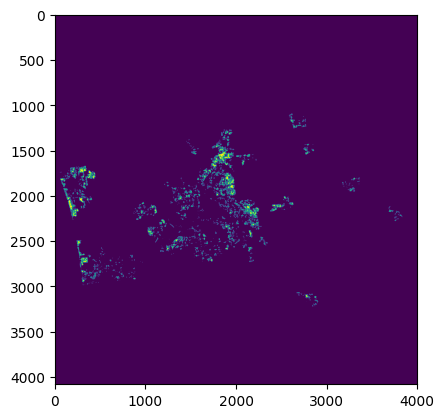

<Axes: >

In [38]:

rasterio.plot.show(landcover_mask)


In [39]:
np.unique(valid_gpp_mask, return_counts=True)

(array([False,  True]), array([ 1532188, 14795893]))

In [120]:
nlcd_mask_dict['urban_forest']

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [26]:
gpp_msa_rr_filled.shape

(4081, 4001)

In [40]:
np.unique(gpp_msa_rr_filled)

array([0.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00,
       5.0000e+00, 6.0000e+00, 7.0000e+00, 8.0000e+00, 9.0000e+00,
       1.0000e+01, 1.1000e+01, 1.2000e+01, 1.3000e+01, 1.4000e+01,
       1.5000e+01, 1.6000e+01, 1.7000e+01, 1.8000e+01, 1.9000e+01,
       2.0000e+01, 2.1000e+01, 2.2000e+01, 2.3000e+01, 2.4000e+01,
       2.5000e+01, 2.6000e+01, 2.7000e+01, 2.9000e+01, 3.0000e+01,
       3.1000e+01, 3.3000e+01, 6.5535e+04,        nan], dtype=float32)

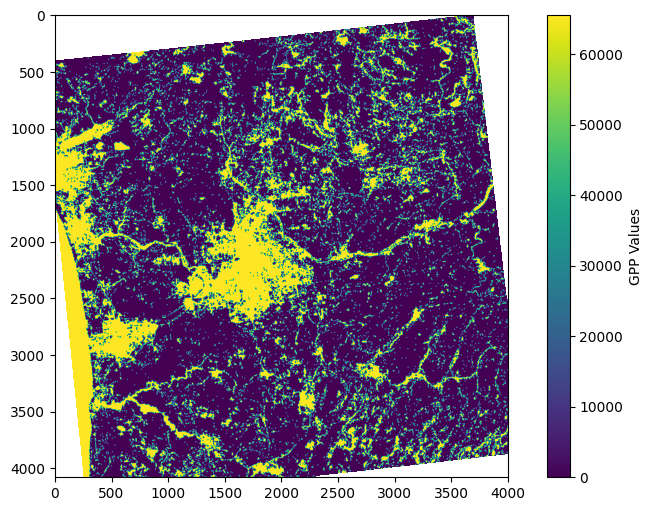

In [41]:
# rasterio.plot.show(gpp_msa_rr_filled)

fig, ax = plt.subplots(figsize=(10, 6)) 
cax = ax.imshow(gpp_msa_rr_filled, cmap='viridis')  # Use a colormap of your choice
cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
cbar.set_label("GPP Values")
plt.show()

In [49]:

save_tiff(gpp_msa_rr_filled, '../output/gpp_msa_rr_filled1.tif', nlcd_crs, nlcd_clip_transform)

GeoTIFF saved to ../output/gpp_msa_rr_filled1.tif


In [ ]:
# # Metadata for the output TIFF
# output_path = "../output/gpp_msa_rr_filled.tif"

# # Write the ndarray to a GeoTIFF
# with rasterio.open(
#     output_path,
#     "w",
#     driver="GTiff",
#     height=gpp_msa_rr_filled.shape[0],
#     width=gpp_msa_rr_filled.shape[1],
#     count=1,  # Number of bands
#     dtype=gpp_msa_rr_filled.dtype,
#     crs=nlcd_crs,
#     transform=nlcd_clip_transform,
#     nodata=np.nan,
# ) as dst:
#     # Write data to the first band
#     dst.write(gpp_msa_rr_filled, 1)

# print(f"GeoTIFF saved to {output_path}")

GeoTIFF saved to ../output/gpp_msa_rr_filled.tif


In [10]:
gpp_msa_rr_filled.shape

(4081, 4001)

In [11]:
nee_msa.shape

(13, 18)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [42]:
# Create an empty array for the reprojected and resampled GPP data
            # reproject(
            #     source=nee_msa,
            #     destination=nee_msa_fine,
            #     src_transform=nee_clip_transform,
            #     src_crs=nee_crs,
            #     dst_transform=nlcd_clip_transform,
            #     dst_crs=nlcd_crs,
            #     resampling=Resampling.nearest, # use nearest to prevent unreasonable upscaling
            #     src_nodata=-9999
            # )


gpp_filled_coarse = np.empty_like(nee_msa, dtype=np.float32)

# Reproject and resample GPP to match NEE's CRS, resolution, and extent
reproject(
    source=gpp_msa_rr_filled,  # Your filled GPP raster
    destination=gpp_filled_coarse,  # Empty array to hold the resampled data
    src_transform=nlcd_clip_transform,  # Transform of the original GPP data
    src_crs=nlcd_crs,  # CRS of the original GPP data
    dst_transform=nee_clip_transform,  # Transform of the clipped NEE data
    dst_crs=nee_crs,  # CRS of the clipped NEE data
    resampling=Resampling.average,  # Use nearest neighbor resampling
    # src_nodata=np.nan,  # Set source nodata value
    # dst_nodata=np.nan  # Set destination nodata value
)


(array([[    0.    ,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan,
                nan,        nan,        nan],
        [    0.    , 14172.157 , 10153.872 ,  5850.8516,  7053.7915,
          8606.763 , 13312.159 ,  9171.484 ,  5946.9536,  7994.438 ,
         11846.18  , 12104.386 ,  6060.457 , 16252.988 , 16032.654 ,
          7669.9517, 14963.048 ,        nan],
        [30643.43  , 32363.334 , 29966.922 , 13087.577 , 15072.818 ,
          7017.5664,  8786.61  , 12240.83  ,  8286.491 , 19324.352 ,
         24542.896 , 13832.83  , 12853.517 , 15304.136 , 17728.416 ,
         11906.52  , 15857.153 ,        nan],
        [65535.    , 60444.062 , 26058.234 ,  9348.279 ,  8548.257 ,
          8177.3857,  4654.137 , 14921.185 , 17793.375 , 19643.947 ,
          9302.221 , 22627.807 , 21202.367 , 17355.318 , 17263.254 ,
         13683.27  ,  9266.622 ,  

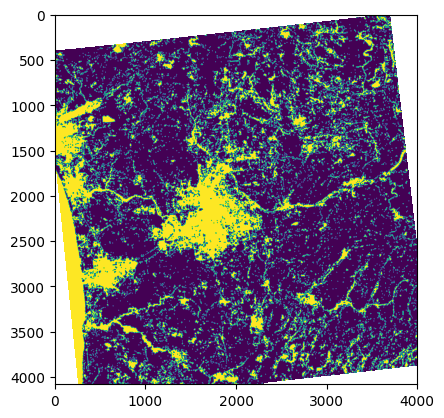

<Axes: >

In [43]:
rasterio.plot.show(gpp_msa_rr_filled)

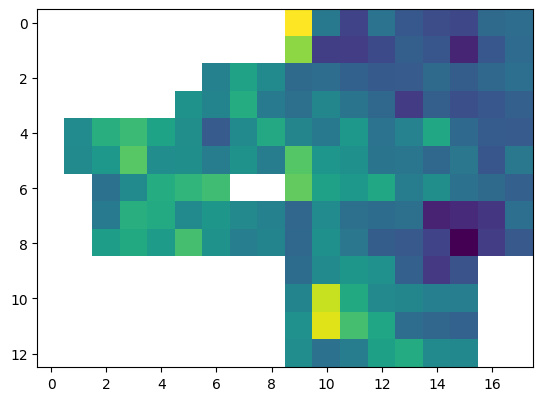

<Axes: >

In [44]:
rasterio.plot.show(nee_msa)

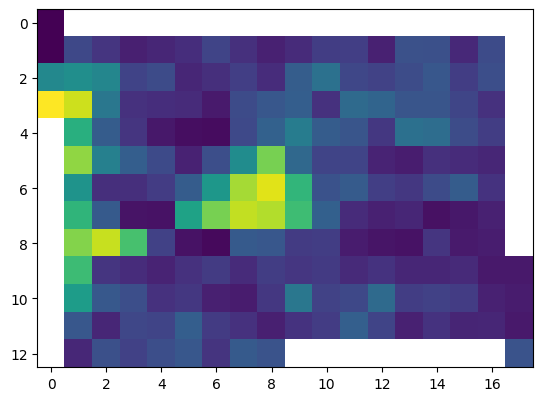

<Axes: >

In [45]:
rasterio.plot.show(gpp_filled_coarse)

In [46]:
save_tiff(gpp_filled_coarse, '../output/gpp_filled_coarse1.tif',nee_crs, nee_clip_transform)

GeoTIFF saved to ../output/gpp_filled_coarse1.tif


In [47]:
print(gpp_filled_coarse.shape)
print(gpp_msa_rr_filled.shape)
print(nee_msa_fine.shape)
print(nee_msa.shape)

(13, 18)
(4081, 4001)
(4081, 4001)
(13, 18)


In [48]:
nee_msa

array([[       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.6339823 ,
        0.3305392 , 0.22846764, 0.31859183, 0.26502812, 0.2452473 ,
        0.23473789, 0.3011904 , 0.30799517],
       [       nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan, 0.5475255 ,
        0.21936128, 0.2187183 , 0.24022157, 0.2790207 , 0.2609755 ,
        0.1781315 , 0.26419747, 0.30228463],
       [       nan,        nan,        nan,        nan,        nan,
               nan, 0.34946114, 0.4192381 , 0.36828816, 0.30173126,
        0.30724463, 0.28262517, 0.26973855, 0.2717535 , 0.30148038,
        0.27553472, 0.29722124, 0.31176144],
       [       nan,        nan,        nan,        nan,        nan,
        0.38554823, 0.3539543 , 0.44050312, 0.33440498, 0.3131183 ,
        0.35867006, 0.3206866 , 0.29754928, 0.2130663 , 0.2785477 ,
        0.2492781 , 0.26426473, 0.28085175],
    

In [17]:

save_tiff(nee_msa / gpp_filled_coarse, 'ratio1.tif', nee_crs, nee_clip_transform)

GeoTIFF saved to ratio1.tif


C:\Users\qifanw\AppData\Local\Temp\1\ipykernel_31648\3696127489.py:1: RuntimeWarning: divide by zero encountered in divide
  save_tiff(nee_msa / gpp_filled_coarse, 'ratio1.tif', nee_crs, nee_clip_transform)


## nee

In [206]:
nc_ds.attrs

{'Comment': 'Ensemble median of 9 members',
 'Version': 'v1',
 'TYPE': 'ensemble',
 'SETUP': 'RS',
 'Temporal_Resolution_tRESO': 'monthly',
 'Reference': 'Jung et al. 2020 [https://doi.org/10.5194/bg-2019-368], Tramontana et al. 2016 [doi:10.5194/bg-13-4291-2016]',
 'Institution': 'MPI-BGC-BGI',
 'Provided_By': 'Martin Jung [mjung@bgc-jena.mpg.de] on behalf of FLUXCOM team',
 'Created_By': 'Fabian Gans [fgans@bgc-jena.mpg.de], Ulrich Weber [uweber@bgc-jena.mpg.de]',
 'Aggregation_Method': 'first interpolate to daily,  second aggregate to monthly mean',
 'History': 'created: Wed Jan 15 17:31:17 2020',
 'Meteorolgical_Data_METEO': 'NONE',
 'Flux_Partitioning_FP': 'NONE',
 'Machine_Learning_Method_MLM': 'MTEM,GMDH_CV,MTEV,MTE,KRR,MARS,SVM,ANN,RF',
 'Spatial_Resolution_sRESO': '4320_2160',
 'Temporal_Aggregation_Method': 'first interpolate to daily,  second aggregate to monthly mean'}

In [159]:
import netCDF4 as nc

nee_file = "../urban_greening/NEE.RS.FP-NONE.MLM-ALL.METEO-NONE.4320_2160.monthly.2015.nc"
ds = nc.Dataset(nee_file)


In [275]:
data = ds['NEE'][:]

In [240]:
data.shape

(12, 2160, 4320)

In [ ]:
nee_month = data[0]

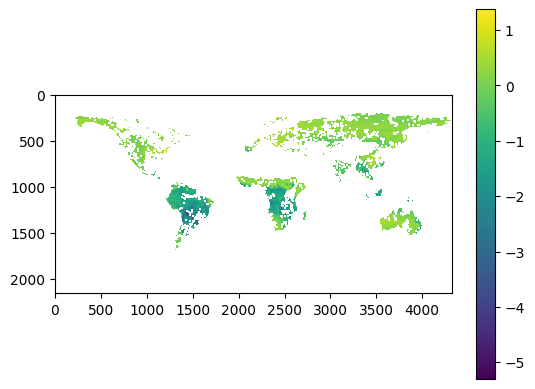

In [246]:
plt.imshow(nee_month)
plt.colorbar()

In [284]:
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
from shapely.geometry import mapping

nee_month_regular = np.ma.filled(nee_month, fill_value=np.nan)

clipped = nee_month_regular.rio.clip([mapping(msa.geometrt)], msa_crs, drop=True)
clipped

AttributeError: 'numpy.ndarray' object has no attribute 'rio'

In [278]:
nlcd_dstrd

<closed DatasetReader name='../urban_greening/nov.15/nlcd_2016_land_cover_l48_20210604.img' mode='r'>

In [277]:
nee_month

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0,
  dtype=float32)

In [247]:
nee_month

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-9999.0,
  dtype=float32)

In [255]:
# get crs and transform for nee

info = nee_file.split('/')[-1].split('.')
var_name = info[0]
ML_method = info[3]
year = info[7]
partitioning_method = info[2]

import xarray as xr
nee_ds = xr.open_dataset(nee_file)
# calc transform for this resolution, given the data is worldwide (the original metadata is incorrect)
minx, miny, maxx, maxy = -180.0, -90.0, 180.0, 90.0
resolution_x = 360 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[0])
resolution_y = 180 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[1])
nee_transform = rasterio.transform.from_origin(minx, maxy, resolution_x, resolution_y)

nee_crs = gpp_crs # assume it's same



In [ ]:
with rasterio.open(raster_path) as src:
    clipped_array, clipped_transform = mask(src, geometries, crop=True)




    with rasterio.open(gpp_file) as gpp_dstrd:
    Vector=msa.to_crs(gpp_dstrd.crs)
    msa_crs = Vector.crs
    gpp_crs = gpp_dstrd.crs
    gpp_clip_image, gpp_clip_transform=mask(gpp_dstrd,Vector.geometry,crop=True)

    gpp_msa = gpp_clip_image[:][:][0]
    
    

    from shapely.geometry import mapping
    geometries = [mapping(geom) for geom in msa.geometry]

    with rasterio.open(nlcd_file) as nlcd_dstrd:
        nlcd_crs = nlcd_dstrd.crs
        
        msa_crsr = msa.to_crs(nlcd_crs)

In [257]:
ds = xr.open_dataset(nee_file)

# Select a specific time slice
nee_month = ds.sel(time=ds.time[0])
nee_month

<xarray.Dataset> Size: 75MB
Dimensions:    (latitude: 2160, longitude: 4320)
Coordinates:
    time       datetime64[ns] 8B 2015-01-31T00:00:00.000040
  * latitude   (latitude) float64 17kB 89.96 89.87 89.79 ... -89.88 -89.96
  * longitude  (longitude) float64 35kB -180.0 -179.9 -179.8 ... 179.9 180.0
Data variables:
    NEE        (latitude, longitude) float32 37MB ...
    NEE_mad    (latitude, longitude) float32 37MB ...
Attributes: (12/16)
    Comment:                      Ensemble median of 9 members
    Version:                      v1
    TYPE:                         ensemble
    SETUP:                        RS
    Temporal_Resolution_tRESO:    monthly
    Reference:                    Jung et al. 2020 [https://doi.org/10.5194/b...
    ...                           ...
    History:                      created: Wed Jan 15 17:31:17 2020
    Meteorolgical_Data_METEO:     NONE
    Flux_Partitioning_FP:         NONE
    Machine_Learning_Method_MLM:  MTEM,GMDH_CV,MTEV,MTE,KRR,MARS,SVM,ANN,RF
    Spatial_Resolution_sRESO:     4320_2160
    Temporal_Aggregation_Method:  first interpolate to daily,  second aggrega...

In [258]:
lat = ds["latitude"]  # Replace with your latitude variable name
lon = ds["longitude"] 

<xarray.DataArray 'latitude' (latitude: 2160)> Size: 17kB
array([ 89.958333,  89.874999,  89.791666, ..., -89.791667, -89.875   ,
       -89.958333])
Coordinates:
  * latitude  (latitude) float64 17kB 89.96 89.87 89.79 ... -89.79 -89.88 -89.96 <xarray.DataArray 'longitude' (longitude: 4320)> Size: 35kB
array([-179.958333, -179.875   , -179.791667, ...,  179.791665,  179.874999,
        179.958332])
Coordinates:
  * longitude  (longitude) float64 35kB -180.0 -179.9 -179.8 ... 179.9 180.0


In [262]:
transform = rasterio.transform.from_bounds(lon.min(), lat.min(), lon.max(), lat.max(), len(lon), len(lat))

In [ ]:
mask = geometry_mask(
    [msa.geometry],
    transform=transform,
    invert=True,
    out_shape=(len(lat), len(lon))
)

C:\Users\qifanw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'FeatureCollection', 'features': [{'id': '6', 'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': (((786115.2703000009, 2276194.1306), (786734.0045000017, 2276250.198999999), (787805.5251000002, 2276349.4155), (790688.6988000013, 2276609.226500001), (791108.8968999982, 2276644.6488000005), (791495.9611000009, 2276681.1680999994), (793517.9767000005, 2276881.567399999), (794483.5518999994, 2276970.2468999997), (794638.1460999995, 2276984.2963999994), (796258.2875000015, 2277133.6834999993), (797591.5115999989, 2277288.5666000005), (802636.9618000016, 2277883.2807), (805075.2653999999, 2278152.9838999994), (805097.4726000018, 2278155.8236999996), (805840.053199999, 2278235.5007000007), (806634.2179999985, 2278349.239600001), (811047.1433999985,

In [264]:
data_array = nee_month["NEE"]  # Replace with your variable name
masked_data = data_array.where(mask)

In [266]:
clipped_array = np.where(mask, data_array.values, np.nan)

In [271]:
np.nanmean(clipped_array)

C:\Users\qifanw\AppData\Local\Temp\1\ipykernel_18952\3670577467.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(clipped_array)


np.float32(nan)

In [268]:
clipped_array.shape

(2160, 4320)

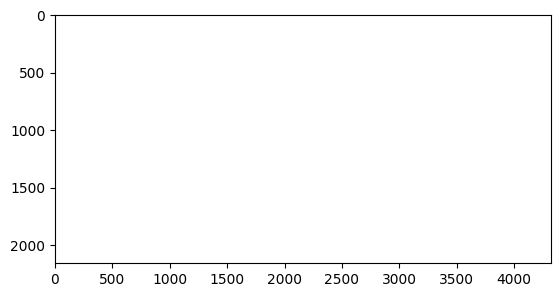

<Axes: >

In [270]:
rasterio.plot.show(clipped_array)

# fold

In [229]:
nee_file = "../urban_greening/NEE.RS.FP-NONE.MLM-ALL.METEO-NONE.4320_2160.monthly.2015.nc"

info = nee_file.split('/')[-1].split('.')
var_name = info[0]
ML_method = info[3]
year = info[7]
partitioning_method = info[2]

import xarray as xr
nee_ds = xr.open_dataset(nee_file)
# calc transform for this resolution, given the data is worldwide (the original metadata is incorrect)
minx, miny, maxx, maxy = -180.0, -90.0, 180.0, 90.0
resolution_x = 360 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[0])
resolution_y = 180 / int(nee_ds.attrs['Spatial_Resolution_sRESO'].split('_')[1])
nee_transform = rasterio.transform.from_origin(minx, maxy, resolution_x, resolution_y)

import rioxarray

nee_ds.rio.write_crs("epsg:4326", inplace=True)

nee_ds.rio.clip(msa.geometry.apply(mapping), msa_crs, drop=True)
# nee_crs = gpp_dstrd.crs # assume is epsg:4326, same as gpp
# from rasterio import features
# features.geometry_mask(msa, transform=nee_crs,
#                     invert=True,
#                     out_shape=(nee_ds.rio.height, nee_ds.rio.width))



# with rasterio.open(nee_file) as nee_dstrd:
#     nee_crs = gpp_dstrd.crs # assume is epsg:4326, same as gpp
#     print(nee_dstrd.meta)

#     nee_dstrd = nee_dstrd.write_crs(nee_dstrd)  # Attach CRS if missing
# # transform = ds.rio.transform() 

#     # NEE = nee_dstrd.read()

#     # nee_clip_image, nee_transform = mask(nee_dstrd,msa.geometry,crop=True)
    

    #     Vector=msa.to_crs(gpp_dstrd.crs)
    # msa_crs = Vector.crs
    # gpp_crs = gpp_dstrd.crs
    # gpp_clip_image, gpp_clip_transform=mask(gpp_dstrd,Vector.geometry,crop=True)

    # gpp_msa = gpp_clip_image[:][:][0]
    
    # print("CRS:", src.crs)

    # # Get the resolution
    # print("Resolution:", src.res)

    # # Optional: Inspect other metadata
    # print("Metadata:", src.meta)

NoDataInBounds: No data found in bounds. Data variable: NEE

In [214]:
nee_dstrd.read('NEE')

ValueError: Can't read closed raster file

In [211]:
import xarray as xr

nc_ds = xr.open_dataset(nee_file)
nee = nc_ds['NEE'][:]



nee['']

<closed DatasetReader name='../urban_greening/NEE.RS.FP-NONE.MLM-ALL.METEO-NONE.4320_2160.monthly.2015.nc' mode='r'>

In [ ]:

data = []
time =  nee.time[0]



nee_month = nc_var.sel(time=time)
nc_arr_vals = nc_arr.values

time_val = time.astype('datetime64[M]').astype(str)